## Imports

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
projectdir = "/home/jovyan/work/MED_Fall"
workdir = "/home/jovyan/work"

In [3]:
import os

os.environ["PYTHONPATH"]

'/home/jovyan/work/MED_Fall/'

In [24]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Dense,
    Flatten,
    Dropout,
    Conv3D,
    MaxPool3D,
    Input,
    BatchNormalization,
)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

from vision.pre_processing.extract_frames import FramesExtractor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from utils.utility_functions import listdir_nohidden_sorted as lsdir
from utils.utility_functions import load_images, show_images

from test_scripts.load_images import get_video_seq

In [19]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Setup the dataframe for keras flow_from_dataframe pipeline

In [6]:
extracted_frames_path = (
    "/home/jovyan/work/MED_Fall/vision/vision_dataset/extracted_frames"
)

In [12]:
ground_truth_old_path = (
    "/home/jovyan/work/MED_Fall/vision/vision_dataset/ground_truth_old"
)
ground_truth_path = "/home/jovyan/work/MED_Fall/vision/vision_dataset/ground_truth"
len(lsdir(ground_truth_path))

50

In [9]:
dfs = []
for file in lsdir(ground_truth_path):
    df = pd.read_csv(file)
    dfs.append(df)
dataset = pd.concat(dfs, ignore_index=True)

dataset = dataset.iloc[:, 1:]
dataset

,micro_labels,macro_labels,ar_labels
0,lie_still,lying_down,actor_repositioning
1,lie_still,lying_down,actor_repositioning
2,lie_still,lying_down,actor_repositioning
3,lie_still,lying_down,actor_repositioning
4,lie_still,lying_down,actor_repositioning
...,...,...,...
1182295,stand_up_from_floor,adl,actor_repositioning
1182296,stand_up_from_floor,adl,actor_repositioning
1182297,stand_up_from_floor,adl,actor_repositioning
1182298,stand_up_from_floor,adl,actor_repositioning


In [13]:
dfs_old = []
for file in lsdir(ground_truth_old_path):
    df_old = pd.read_csv(file)
    dfs_old.append(df_old)
dataset_old = pd.concat(dfs_old, ignore_index=True)

In [15]:
dataset["frame_name"] = (
    dataset_old["frame_name"] + ".jpg"
)  # add extension to file_names

dataset = dataset.iloc[:, 1:]
dataset

,macro_labels,ar_labels,frame_name
0,lying_down,actor_repositioning,actor_1_bed_cam_1_0000.jpg
1,lying_down,actor_repositioning,actor_1_bed_cam_1_0001.jpg
2,lying_down,actor_repositioning,actor_1_bed_cam_1_0002.jpg
3,lying_down,actor_repositioning,actor_1_bed_cam_1_0003.jpg
4,lying_down,actor_repositioning,actor_1_bed_cam_1_0004.jpg
...,...,...,...
1182295,adl,actor_repositioning,actor_4_chair_full_ph_cam_7_4615.jpg
1182296,adl,actor_repositioning,actor_4_chair_full_ph_cam_7_4616.jpg
1182297,adl,actor_repositioning,actor_4_chair_full_ph_cam_7_4617.jpg
1182298,adl,actor_repositioning,actor_4_chair_full_ph_cam_7_4618.jpg


In [22]:
batch = get_video_seq(dataset["frame_name"][:10])

(10, 224, 224, 3)


In [ ]:
## input layer
input_layer = Input((10, 224, 224, 3))

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 3), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 3), activation='relu')(conv_layer1)

## add max pooling to obtain the most imformatic features
pooling_layer1 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer2)

conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(pooling_layer1)
conv_layer4 = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu')(conv_layer3)
pooling_layer2 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer4)

## perform batch normalization on the convolution outputs before feeding it to MLP architecture
pooling_layer2 = BatchNormalization()(pooling_layer2)
flatten_layer = Flatten()(pooling_layer2)

## create an MLP architecture with dense layers : 4096 -> 512 -> 10
## add dropouts to avoid overfitting / perform regularization
dense_layer1 = Dense(units=2048, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=512, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=10, activation='softmax')(dense_layer2)

## define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)

### Visualize some frames from the dataset

In [13]:
##removector repositioning

on_air_ds = dataset.loc[dataset["ar_labels"] == "on_air"]
on_air_ds

,micro_labels,macro_labels,ar_labels,frame_name
206,sit_up_from_lying,adl,on_air,actor_1_bed_cam_1_0206.jpg
207,sit_up_from_lying,adl,on_air,actor_1_bed_cam_1_0207.jpg
208,sit_up_from_lying,adl,on_air,actor_1_bed_cam_1_0208.jpg
209,sit_up_from_lying,adl,on_air,actor_1_bed_cam_1_0209.jpg
210,sit_up_from_lying,adl,on_air,actor_1_bed_cam_1_0210.jpg
...,...,...,...,...
1182213,crouched_still,lying_down,on_air,actor_4_chair_full_ph_cam_7_4533.jpg
1182214,crouched_still,lying_down,on_air,actor_4_chair_full_ph_cam_7_4534.jpg
1182215,crouched_still,lying_down,on_air,actor_4_chair_full_ph_cam_7_4535.jpg
1182216,crouched_still,lying_down,on_air,actor_4_chair_full_ph_cam_7_4536.jpg


In [14]:
dataset.loc[dataset["frame_name"] == "actor_2_chair_cam_1_0528.jpg"]

,micro_labels,macro_labels,ar_labels,frame_name
592728,sit_still,adl,actor_repositioning,actor_2_chair_cam_1_0528.jpg


In [15]:
rand_samples = on_air_ds.groupby("macro_labels").sample(n=10)
rand_samples

,micro_labels,macro_labels,ar_labels,frame_name
957548,sit_up_from_lying,adl,on_air,actor_3_walk_full_ph_cam_4_2588.jpg
839667,sit_up_from_lying,adl,on_air,actor_3_bed_cam_7_0627.jpg
503720,sit_up_from_lying,adl,on_air,actor_2_bed_full_ph_cam_2_3380.jpg
756624,sit_up_from_lying,adl,on_air,actor_2_walk_full_ph_cam_2_1824.jpg
1002923,stand_up_from_sit,adl,on_air,actor_3_walk_stick_full_ph_cam_6_0803.jpg
770536,stand_up_from_sit,adl,on_air,actor_2_walk_full_ph_cam_6_3676.jpg
1156073,stand_up_from_sit,adl,on_air,actor_4_chair_full_ph_cam_2_1493.jpg
491496,sit_up_from_lying,adl,on_air,actor_2_bed_cam_7_5196.jpg
297881,sit_up_from_lying,adl,on_air,actor_1_walk_cam_6_2381.jpg
536610,sit_up_from_lying,adl,on_air,actor_2_bed_ph_cam_6_0270.jpg


In [150]:
##concatenare alla macro label il nome del fotogramma

titles = rand_samples["frame_name"] + rand_samples["macro_labels"]
titles

129476                       actor_1_chair_cam_2_0176.jpgadl
945029                actor_3_walk_full_ph_cam_1_3389.jpgadl
131414                       actor_1_chair_cam_2_2114.jpgadl
396787           actor_1_walk_shoe_full_ph_cam_5_1807.jpgadl
17640                          actor_1_bed_cam_5_0360.jpgadl
800907                     actor_2_walk_ph_cam_5_2067.jpgadl
903352                     actor_3_rolling_cam_6_0832.jpgadl
709153                        actor_2_walk_cam_2_4153.jpgadl
255043               actor_1_walk2_full_ph_cam_6_3943.jpgadl
1174630              actor_4_chair_full_ph_cam_6_1570.jpgadl
1015691                    actor_4_bed_cam_1_1811.jpgfalling
945159            actor_3_walk_full_ph_cam_1_3519.jpgfalling
329227                 actor_1_walk_ph_cam_1_2887.jpgfalling
1174170          actor_4_chair_full_ph_cam_6_1110.jpgfalling
626876                actor_2_chair_ph_cam_1_0656.jpgfalling
961394            actor_3_walk_full_ph_cam_5_1994.jpgfalling
447241              acto

(30, 224, 224, 3)


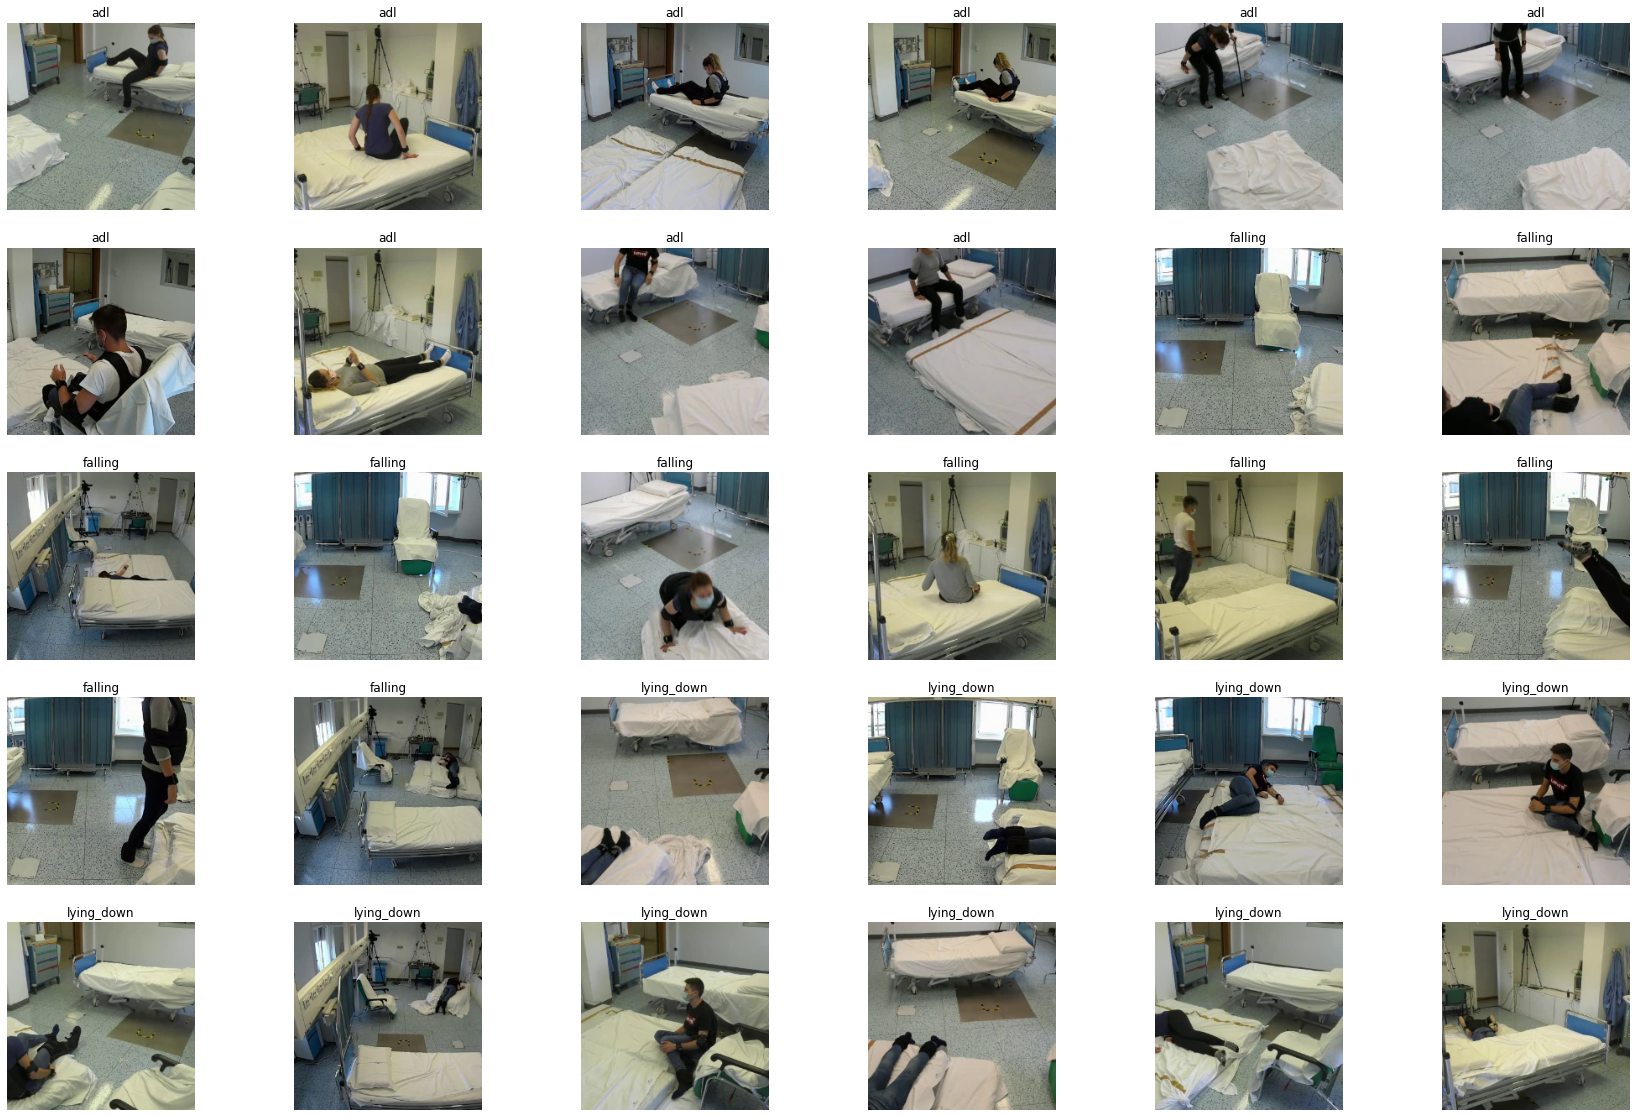

In [17]:
images = load_images(extracted_frames_path, rand_samples["frame_name"])

show_images(images, rows=5, figsize=(30, 20), titles=rand_samples["macro_labels"])

## Subsample dataset choosing Actor 4 as fine tuning data

In [6]:
# select only actor 4
actor_4_dataset = dataset[dataset["frame_name"].str.contains("actor_4")]

NameError: name 'dataset' is not defined

In [14]:
actor_4_dataset.reset_index(drop=True, inplace=True)
actor_4_dataset

,micro_labels,macro_labels,ar_labels,frame_name
0,lie_still,lying_down,actor_repositioning,actor_4_bed_cam_1_0000.jpg
1,lie_still,lying_down,actor_repositioning,actor_4_bed_cam_1_0001.jpg
2,lie_still,lying_down,actor_repositioning,actor_4_bed_cam_1_0002.jpg
3,lie_still,lying_down,actor_repositioning,actor_4_bed_cam_1_0003.jpg
4,lie_still,lying_down,actor_repositioning,actor_4_bed_cam_1_0004.jpg
...,...,...,...,...
168415,stand_up_from_floor,adl,actor_repositioning,actor_4_chair_full_ph_cam_7_4615.jpg
168416,stand_up_from_floor,adl,actor_repositioning,actor_4_chair_full_ph_cam_7_4616.jpg
168417,stand_up_from_floor,adl,actor_repositioning,actor_4_chair_full_ph_cam_7_4617.jpg
168418,stand_up_from_floor,adl,actor_repositioning,actor_4_chair_full_ph_cam_7_4618.jpg


In [15]:
train_set = actor_4_dataset.sample(
    frac=0.9, random_state=2
)  # random state is a seed value
val_set = actor_4_dataset.drop(train_set.index)

print(train_set.shape, val_set.shape)

(151578, 4) (16842, 4)


In [16]:
train_set["macro_labels"].value_counts()

adl           122360
lying_down     20453
falling         8765
Name: macro_labels, dtype: int64

In [17]:
adl_train = train_set.loc[train_set["macro_labels"] == "adl"]
adl_train.reset_index(drop=True, inplace=True)
adl_train

,micro_labels,macro_labels,ar_labels,frame_name
0,lie_down_from_sitting,adl,actor_repositioning,actor_4_bed_cam_3_0445.jpg
1,stand_still,adl,actor_repositioning,actor_4_bed_full_ph_cam_4_7022.jpg
2,stand_up_from_floor,adl,actor_repositioning,actor_4_chair_full_ph_cam_4_2359.jpg
3,sit_up_from_lying,adl,on_air,actor_4_bed_cam_3_1165.jpg
4,sit_up_from_lying,adl,on_air,actor_4_bed_cam_1_0131.jpg
...,...,...,...,...
122355,stand_up_from_floor,adl,actor_repositioning,actor_4_chair_full_ph_cam_4_0746.jpg
122356,lie_down_from_sitting,adl,actor_repositioning,actor_4_bed_full_ph_cam_2_5184.jpg
122357,stand_up_from_sit,adl,on_air,actor_4_bed_full_ph_cam_7_1844.jpg
122358,sit_up_from_lying,adl,on_air,actor_4_bed_full_ph_cam_4_0187.jpg


In [18]:
lying_down_n_samples = train_set["macro_labels"].value_counts()[1]
lying_down_n_samples

20453

In [19]:
adl_train_under = adl_train.sample(n=lying_down_n_samples, random_state=2)
adl_train_under

,micro_labels,macro_labels,ar_labels,frame_name
6011,stand_still,adl,actor_repositioning,actor_4_bed_full_ph_cam_6_10947.jpg
103894,sit_down_from_standing,adl,actor_repositioning,actor_4_bed_cam_7_2736.jpg
121657,stand_up_from_floor,adl,actor_repositioning,actor_4_bed_full_ph_cam_6_2001.jpg
92094,stand_still,adl,actor_repositioning,actor_4_bed_cam_2_2620.jpg
75005,stand_up_from_floor,adl,actor_repositioning,actor_4_chair_full_ph_cam_7_2451.jpg
...,...,...,...,...
100976,stand_still,adl,actor_repositioning,actor_4_bed_full_ph_cam_1_11451.jpg
3589,rolling_bed,adl,on_air,actor_4_bed_rolling_cam_2_0177.jpg
91959,stand_up_from_floor,adl,actor_repositioning,actor_4_chair_cam_4_1063.jpg
35088,stand_up_from_floor,adl,actor_repositioning,actor_4_bed_full_ph_cam_5_3401.jpg


In [20]:
train_set_copy = train_set.copy()
train_set_copy = train_set_copy[train_set_copy["macro_labels"] != "adl"]
train_set_copy

,micro_labels,macro_labels,ar_labels,frame_name
59896,lie_still,lying_down,actor_repositioning,actor_4_bed_full_ph_cam_4_5296.jpg
115867,fall_rolling,falling,on_air,actor_4_bed_rolling_cam_4_0967.jpg
20943,lie_still,lying_down,actor_repositioning,actor_4_bed_full_ph_cam_1_1623.jpg
90841,fall_lateral,falling,on_air,actor_4_bed_full_ph_cam_7_0961.jpg
128548,crouched_still,lying_down,on_air,actor_4_chair_cam_4_1828.jpg
...,...,...,...,...
25898,lie_still,lying_down,actor_repositioning,actor_4_bed_full_ph_cam_1_6578.jpg
24940,lie_still,lying_down,actor_repositioning,actor_4_bed_full_ph_cam_1_5620.jpg
12103,lie_still,lying_down,actor_repositioning,actor_4_bed_cam_5_1063.jpg
142975,lie_down_on_the_floor,lying_down,on_air,actor_4_chair_full_ph_cam_2_2275.jpg


In [21]:
train_set_copy["macro_labels"].value_counts()

lying_down    20453
falling        8765
Name: macro_labels, dtype: int64

In [22]:
train_set_copy = pd.concat([train_set_copy, adl_train_under], axis=0)
train_set_copy

,micro_labels,macro_labels,ar_labels,frame_name
59896,lie_still,lying_down,actor_repositioning,actor_4_bed_full_ph_cam_4_5296.jpg
115867,fall_rolling,falling,on_air,actor_4_bed_rolling_cam_4_0967.jpg
20943,lie_still,lying_down,actor_repositioning,actor_4_bed_full_ph_cam_1_1623.jpg
90841,fall_lateral,falling,on_air,actor_4_bed_full_ph_cam_7_0961.jpg
128548,crouched_still,lying_down,on_air,actor_4_chair_cam_4_1828.jpg
...,...,...,...,...
100976,stand_still,adl,actor_repositioning,actor_4_bed_full_ph_cam_1_11451.jpg
3589,rolling_bed,adl,on_air,actor_4_bed_rolling_cam_2_0177.jpg
91959,stand_up_from_floor,adl,actor_repositioning,actor_4_chair_cam_4_1063.jpg
35088,stand_up_from_floor,adl,actor_repositioning,actor_4_bed_full_ph_cam_5_3401.jpg


## sample actor_1_bed_cam_1

In [36]:
actor_1_bed_cam_1 = dataset[dataset["frame_name"].str.contains("actor_1_bed_cam_1")]
actor_1_bed_cam_1

,micro_labels,macro_labels,ar_labels,frame_name
0,lie_still,lying_down,actor_repositioning,actor_1_bed_cam_1_0000.jpg
1,lie_still,lying_down,actor_repositioning,actor_1_bed_cam_1_0001.jpg
2,lie_still,lying_down,actor_repositioning,actor_1_bed_cam_1_0002.jpg
3,lie_still,lying_down,actor_repositioning,actor_1_bed_cam_1_0003.jpg
4,lie_still,lying_down,actor_repositioning,actor_1_bed_cam_1_0004.jpg
...,...,...,...,...
4315,lie_still,lying_down,actor_repositioning,actor_1_bed_cam_1_4315.jpg
4316,lie_still,lying_down,actor_repositioning,actor_1_bed_cam_1_4316.jpg
4317,lie_still,lying_down,actor_repositioning,actor_1_bed_cam_1_4317.jpg
4318,lie_still,lying_down,actor_repositioning,actor_1_bed_cam_1_4318.jpg


In [37]:
train_set = actor_1_bed_cam_1.sample(frac=0.8, random_state=2)
val_set = actor_1_bed_cam_1.drop(train_set.index)

train_set.shape, val_set.shape

((3456, 4), (864, 4))

In [38]:
train_set_copy = train_set.copy()

## Fine tune VGG16 on Actor 4

### Creating Training and Validation Generators

In [39]:
train_set_copy["macro_labels"].value_counts()

adl           1601
lying_down    1569
falling        286
Name: macro_labels, dtype: int64

In [40]:
train_generator = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)


train_datagen = train_generator.flow_from_dataframe(
    train_set_copy,
    directory=extracted_frames_path,
    x_col="frame_name",
    y_col="macro_labels",
    target_size=(224, 224),
    color_mode="rgb",
    classes=["adl", "lying_down", "falling"],
    class_mode="categorical",
    batch_size=64,
    shuffle=False,
    seed=2,
)

Found 3456 validated image filenames belonging to 3 classes.


In [ ]:
val_generator = ImageDataGenerator(rescale=1.0 / 255)

val_datagen = val_generator.flow_from_dataframe(
    val_set,
    directory=extracted_frames_path,
    x_col="frame_name",
    y_col="macro_labels",
    target_size=(224, 224),
    color_mode="rgb",
    classes=["adl", "lying_down", "falling"],
    class_mode="categorical",
    batch_size=64,
    shuffle=False,
    seed=2,
)

In [42]:
pd.Series(train_datagen.classes).value_counts()

0    1601
2    1569
1     286
dtype: int64

In [43]:
pd.Series(val_datagen.classes).value_counts()

0    419
2    383
1     62
dtype: int64

### Download pre-trained VGG16

In [44]:
IMG_SIZE = (224, 224, 3)

In [45]:
feature_extractor = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=IMG_SIZE,
    pooling="avg",
)

feature_extractor.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Freeze all layers except last convolutional block

In [46]:
# freeze all layers except last five
for layer in feature_extractor.layers[:-9]:
    layer.trainable = False

for i, layer in enumerate(feature_extractor.layers):
    print(i, layer.name, layer.trainable)

0 input_2 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
19 global_average_pooling2d_1 True


### Add top layer to fine tune

In [47]:
x = feature_extractor.output
x = Flatten()(x)
x = Dense(units=512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(units=256, activation="relu")(x)
x = Dense(units=3, activation="softmax")(x)

transfer_model = Model(inputs=feature_extractor.input, outputs=x)

transfer_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

### Compile the model and define callbacks

In [48]:
transfer_model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=[
        "accuracy",
        tf.keras.metrics.Recall(class_id=0),
        tf.keras.metrics.Recall(class_id=1),
        tf.keras.metrics.Recall(class_id=2),
    ],
)

In [49]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    f"{projectdir}/vision/model_checkpoints/resample/vgg_top_fine_tuned_best_epoch_undersample.h5",
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
)

In [50]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(),
    tf.keras.callbacks.EarlyStopping(patience=20),
]

### Train the model

In [51]:
history = transfer_model.fit(
    train_datagen, validation_data=val_datagen, epochs=100, callbacks=callbacks
)

Epoch 1/100
108/108 [==============================] - 29s 265ms/step - loss: 0.9803 - accuracy: 0.4682 - recall_1: 0.3073 - recall_2: 0.0070 - recall_3: 0.2894 - val_loss: 0.9477 - val_accuracy: 0.4433 - val_recall_1: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 2/100
108/108 [==============================] - 28s 262ms/step - loss: 0.9533 - accuracy: 0.4803 - recall_1: 0.3360 - recall_2: 0.0000e+00 - recall_3: 0.2817 - val_loss: 0.9010 - val_accuracy: 0.4433 - val_recall_1: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 3/100
108/108 [==============================] - 28s 261ms/step - loss: 0.8478 - accuracy: 0.5775 - recall_1: 0.3666 - recall_2: 0.0000e+00 - recall_3: 0.5099 - val_loss: 0.5744 - val_accuracy: 0.7975 - val_recall_1: 0.8377 - val_recall_2: 0.0000e+00 - val_recall_3: 0.8773
Epoch 4/100
108/108 [==============================] - 28s 262ms/step - loss: 0.6025 - accuracy: 0.7972 - recall_1: 0.8938 - recall_2: 0.0000e+00 - 

In [60]:
#%cp /home/jovyan/work/MED_Fall/vision/model_checkpoints/vgg_top_fine_tuned_best_epoch.h5 /home/jovyan/work/persistent/

### Evaluate the model

In [61]:
transfer_model.evaluate(val_datagen)

27/27 [==============================] - 2s 55ms/step - loss: 0.0628 - accuracy: 0.9826 - recall_1: 0.9857 - recall_2: 0.8548 - recall_3: 1.0000


[0.06279167532920837,
 0.9826388955116272,
 0.9856801629066467,
 0.8548387289047241,
 1.0]

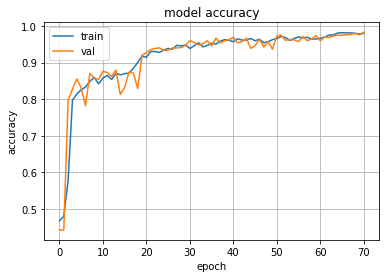

In [62]:
plt.figure()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.grid()
plt.show()

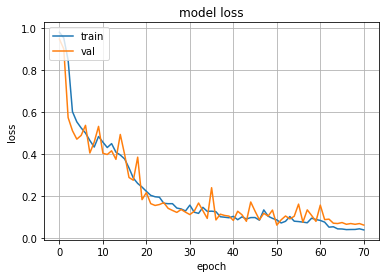

In [63]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.grid()
plt.show()

In [72]:
y_preds_logits = transfer_model.predict(train_datagen)

In [77]:
y_preds_logits[0]

array([1.0000000e+00, 2.4480507e-08, 2.0781130e-08], dtype=float32)

In [82]:
y_preds = np.argmax(y_preds_logits, axis=1)

In [87]:
y_preds[:10]

array([0, 0, 0, 2, 1, 2, 2, 2, 2, 2])

In [86]:
train_datagen.classes[:10]

[0, 2, 0, 0, 2, 0, 0, 2, 0, 2]

In [81]:
print(classification_report(y_true=train_datagen.classes, y_pred=y_preds))

ValueError: Found input variables with inconsistent numbers of samples: [3456, 3]

In [ ]:
pd.Series(train_datagen.classes).value_counts()

In [ ]:
for batch_x, batch_y in train_datagen:
    print(np.argmax(batch_y, axis=-1))